# RNN

## Auto-regression

$x_t$: Time-series

- input $x_t$
- target $y_t=x_{t+1}$

Images from [cnvrg.io](https://cnvrg.io/pytorch-lstm/)
- Simple NN<BR>
![nn](https://cnvrg.io/wp-content/uploads/2020/12/Simple-Neural-Network.jpg)
- RNN<BR>
![rnn](https://cnvrg.io/wp-content/uploads/2020/12/Unfolding-RNNs.jpg)

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import trange
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
print(sm.datasets.sunspots.NOTE)
data = sm.datasets.sunspots.load_pandas().data

data.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2008"))
data.index.freq = data.index.inferred_freq
del data["YEAR"]

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



## 다양한 데이터셋 구성 방법

1. 시계열 전체를 처음부터 외워서 다음을 맞추기
2. 이전 몇개를 보고 다음을 맞추기 (look-back window)

<Axes: >

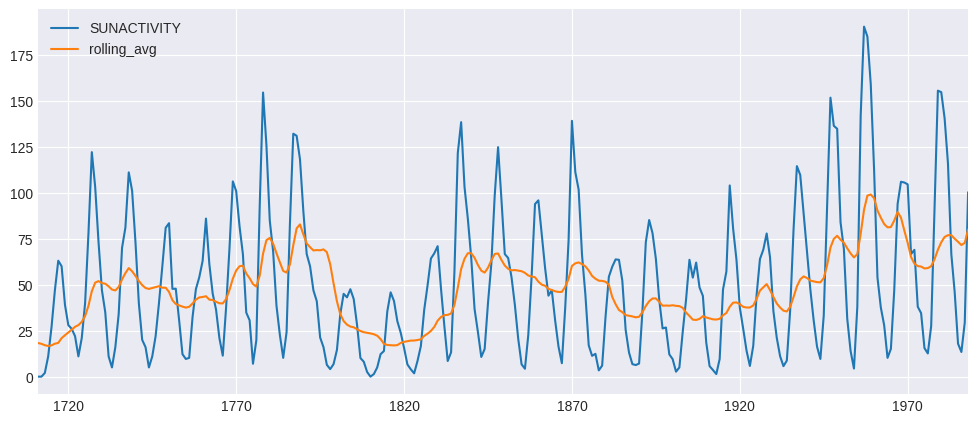

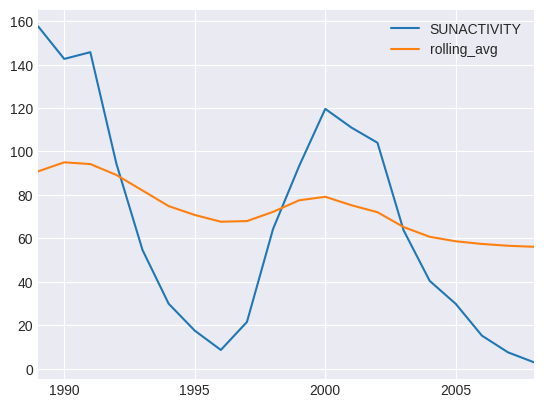

In [ ]:
tst_size = 20

data_mw = data.copy()
data_mw['rolling_avg'] = data.SUNACTIVITY.rolling(12).mean()
data_mw = data_mw.dropna()

trn, tst = data_mw[:-tst_size], data_mw[-tst_size:]

scaler = MinMaxScaler()
scaler_ra = MinMaxScaler()

trn_scaled, tst_scaled = trn.copy(), tst.copy()

trn_scaled['SUNACTIVITY'] = scaler.fit_transform(trn.SUNACTIVITY.to_numpy(np.float32).reshape(-1,1))
trn_scaled['rolling_avg'] = scaler_ra.fit_transform(trn.rolling_avg.to_numpy(np.float32).reshape(-1,1))

tst_scaled['SUNACTIVITY'] = scaler.transform(tst.SUNACTIVITY.to_numpy(np.float32).reshape(-1,1))
tst_scaled['rolling_avg'] = scaler_ra.transform(tst.rolling_avg.to_numpy(np.float32).reshape(-1,1))

trn_scaled = trn_scaled.to_numpy(np.float32)
tst_scaled = tst_scaled.to_numpy(np.float32)

ax = trn.plot(figsize=(12,5))
tst.plot()

## LSTM




[torch.nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

`torch.nn.LSTM(self, input_size, hidden_size, num_layers=1, batch_first=True, proj_size=0)`

- `x`: output (aka hidden states), shape: `(batch_size, sequence_length, hidden_size)`
- `hn`: the final hidden state, shape: `(num_layers, batch_size, hidden_size)`
- `cn`: the final cell state, shape: `(num_layers, batch_size, hidden_size)`

In [ ]:
x = torch.randn(64, 2)
lstm = nn.LSTM(2, 4, 1)

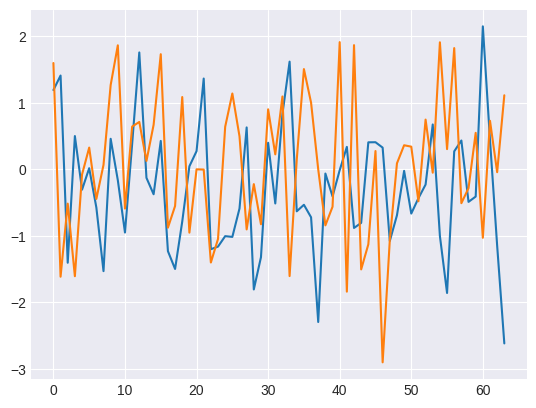

In [ ]:
plt.plot(x)

In [ ]:
x, (hn,cn) = lstm(x)

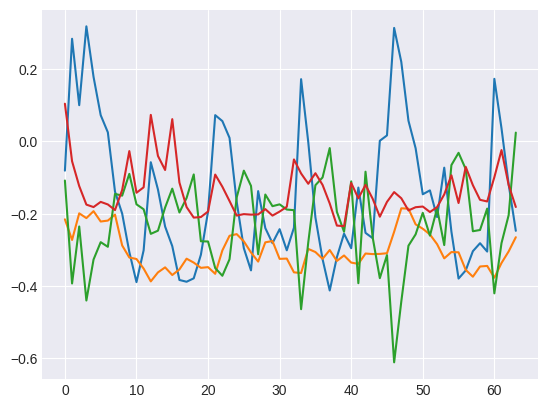

In [ ]:
plt.plot(x.detach().numpy())

In [ ]:
x[-1] == hn.flatten()

tensor([True, True, True, True])

In [ ]:
hn

tensor([[-0.2475, -0.2651,  0.0240, -0.1816]], grad_fn=<SqueezeBackward1>)

### 전체 외우기
- No mini-batch
- model remembers the hidden states (stateful RNN)

In [ ]:
class StatefulLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super().__init__()
    self.reset_state()
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
    self.head = nn.Linear(hidden_size, output_size)

  def reset_state(self, state=None):
    self.state = state

  def forward(self, x):
    assert x.dim() == 2   # (sequence_length, input_size)
    if self.state is None:
      x, (hn, cn) = self.rnn(x)   # state will be set to be zeros by default
    else:
      x, (hn, cn) = self.rnn(x, self.state)   # pass the saved state
    # x.shape == (sequence_length, hidden_size)
    self.reset_state((hn.detach(), cn.detach()))  # save the state
    x = self.head(x)  # (sequence_length, output_size)
    return F.sigmoid(x)

  def predict(self, x0, steps, state=None):
    if state is not None:
      self.reset_state(state)
    output = []
    x = x0.reshape(1,-1)
    for i in range(steps):
      x = self.forward(x)
      output.append(x)
    return torch.concat(output, 0)

In [ ]:
batch_size = 64
trn_x = torch.tensor(trn_scaled[:-1]).split(batch_size)
trn_y = torch.tensor(trn_scaled[1:]).split(batch_size)

tst_y = torch.tensor(tst_scaled)

trn_x[0].shape, trn_y[0].shape

(torch.Size([64, 2]), torch.Size([64, 2]))

In [ ]:
rnn = StatefulLSTM(2, 8, 2, 1)
rnn.to(device)

optim = torch.optim.AdamW(rnn.parameters(), lr=0.001)

pbar = trange(1000)
for e in pbar:
  rnn.train()
  rnn.reset_state()
  trn_loss = .0
  for x, y in zip(trn_x, trn_y):
    x, y = x.to(device), y.to(device)
    optim.zero_grad()
    p = rnn(x)
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()
  trn_loss /= len(trn)-1

  rnn.eval()
  with torch.inference_mode():
    p = rnn.predict(y[-1:].to(device), len(tst_y))
    tst_loss = F.mse_loss(p, tst_y.to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
def mape(input, target):
  return (np.abs(input - target)/target).mean() * 100

def mae(input, target):
  return np.abs(input - target).mean()

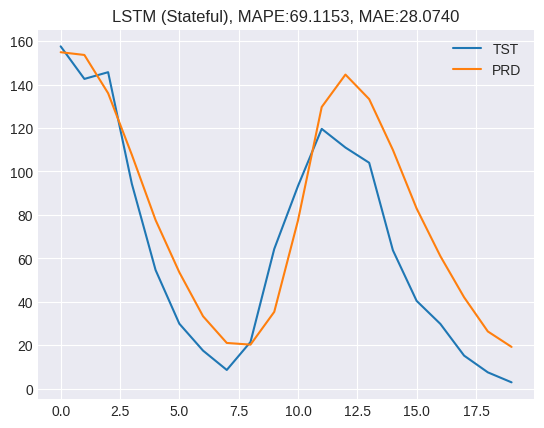

In [ ]:
prd = scaler.inverse_transform(p.cpu())[:,:1]

plt.title(f"LSTM (Stateful), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}")
plt.plot(tst.SUNACTIVITY.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

In [ ]:
tst.to_numpy().shape

(20, 2)

- 실제 모델을 사용할 때, $t=0$ 부터 다시 데이터를 모두 집어넣어야 합니다.

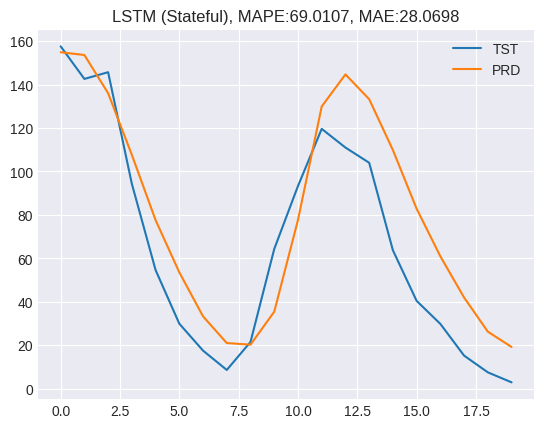

In [ ]:
rnn.eval()

# To get states of the model
rnn.reset_state()
with torch.inference_mode():
  for x in trn_x:
    x = x.to(device)
    p = rnn(x)
  p = rnn.predict(y[-1:].to(device), len(tst_y))

prd = scaler.inverse_transform(p.cpu()[:,:1])

plt.title(f"LSTM (Stateful), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}")
plt.plot(tst.SUNACTIVITY.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

- 처음부터 시작하지 않으면, 잘못된 값을 줍니다.

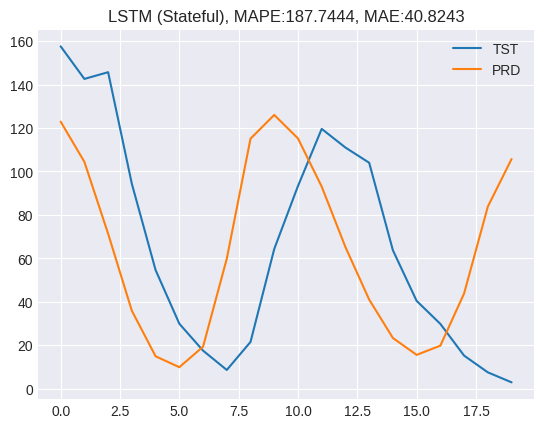

In [ ]:
rnn.eval()

# To get states of the model
rnn.reset_state()
with torch.inference_mode():
  # for x in trn_x:
  #   x = x.to(device)
  #   p = rnn(x)
  p = rnn.predict(y[-1:].to(device), len(tst_y))

prd = scaler.inverse_transform(p.cpu()[:,:1])

plt.title(f"LSTM (Stateful), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}")
plt.plot(tst.SUNACTIVITY.to_numpy(), label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

- 이유는 state 에 아무값도 들어있지 않기 때문 입니다.

In [ ]:
drnn.eval()

# To get states of the model
rnn.reset_state()
print(rnn.state)

In [ ]:
rnn.reset_state()
with torch.inference_mode():
  for x in trn_x:
    x = x.to(device)
    p = rnn(x)

print(rnn.state)

## Look-back Window

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, lookback_size:int, shift_size:int):
    self.lookback_size = lookback_size
    self.shift_size = shift_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.lookback_size - self.shift_size + 1

  def __getitem__(self, i):
    idx = (i+self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[i+self.shift_size:idx+self.shift_size]

    return look_back, forecast

In [ ]:
window_size = 32

trn_ds = TimeSeriesDataset(trn_scaled, window_size, 1)
tst_ds = TimeSeriesDataset(np.concatenate([trn_scaled[-window_size:], tst_scaled], axis=0), window_size, 1)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=64, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=len(tst_ds), shuffle=False)

In [ ]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([64, 32, 2]), torch.Size([64, 32, 2]))

In [ ]:
lstm = nn.LSTM(2,8,1,batch_first=True)
head = nn.Linear(8, 2)

In [ ]:
x, _ = lstm(x)
x.shape

torch.Size([64, 32, 8])

In [ ]:
x = head(x)
x.shape

torch.Size([64, 32, 2])

In [ ]:
class StatelessLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super().__init__()
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.head = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x, _ = self.rnn(x)   # state will be set to be zeros by default
    # x.shape == (batch_size, sequence_length, hidden_size)
    x = self.head(x)  # (batch_size, sequence_length, output_size)
    return F.sigmoid(x)

  def predict(self, x, steps, state=None):
    output = []
    for i in range(steps):
      x = self.forward(x)
      output.append(x[-1:])
    return torch.concat(output, 0)

In [ ]:
rnn = StatelessLSTM(2, 8, 2, 2)
rnn.to(device)

x, y = next(iter(tst_dl))
rnn.predict(x[0].to(device), 20).shape

In [ ]:
rnn = StatelessLSTM(2, 8, 2, 2)
rnn.to(device)

optim = torch.optim.AdamW(rnn.parameters(), lr=0.001)

pbar = trange(1000)
for e in pbar:
  rnn.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.to(device), y.to(device)
    optim.zero_grad()
    p = rnn(x)
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()
  trn_loss /= len(trn)-1

  rnn.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    p = rnn.predict(x[0].to(device), len(tst_scaled))[:,:1]
    tst_loss = F.mse_loss(p, torch.tensor(tst_scaled[:,:1]).view(-1,1).to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})

In [ ]:
prd = scaler.inverse_transform(p.cpu())
# prd = p.cpu()

plt.title(f"LSTM (Look-back window), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}")
plt.plot(tst.to_numpy()[:,:1], label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()